# COSC522 Fall 2022 Final Project - 5-LDR

## Team Members
Dan Scott <br>
Adam McDaniel<br>
Logan Wrinkle<br>

This notebook sets up the labels and models for the 5-LDR configuration.

In [1]:
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
from datetime import datetime
import datetime
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

## Gather Data from raw LDR values

The data for the 5-LDR models was captured on the Raspberry Pi and transfered to the raw data folder. A file of 100+ events was produced for each direction and saved with the direction (D0, D1,...) in the file name to make identification by programatic means possible.

In [2]:
root = os.getcwd()
data = '../data/raw_data_do_not_edit/'

#list of all CSV files in directory
list_of_all_files = glob(os.path.join(data, 'output_5*.txt'))
list_of_all_files.sort()
from pprint import pprint  
pprint(list(enumerate(list_of_all_files, start=0)))

[(0, '../data/raw_data_do_not_edit\\output_5_D0.txt'),
 (1, '../data/raw_data_do_not_edit\\output_5_D1.txt'),
 (2, '../data/raw_data_do_not_edit\\output_5_D2.txt'),
 (3, '../data/raw_data_do_not_edit\\output_5_D3.txt'),
 (4, '../data/raw_data_do_not_edit\\output_5_D4.txt'),
 (5, '../data/raw_data_do_not_edit\\output_5_D5.txt'),
 (6, '../data/raw_data_do_not_edit\\output_5_D7.txt')]


In [3]:
#General purpose read CSV with NO data types infered, this is needed because the time stamp does not auto convert using pandas
def getCSVData(fname):
    List_data=[]
    with open(fname) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            List_data.append(row)
            line_count+=1  
    return List_data

## Global parameters for identifing the events based on the average percent change over N rows

In [4]:
N = 18       # Rolling average over N rows
rLen = 20    # use this many rows of data to predict 
PCT = 0.01   # flag if any change in percentage from previous row changes by PCT

## Labeling Data
### Add columns that will help identify an 'Event'

In [5]:
def fixDF(datafrm, direction):
    datafrm['Class']= 'D99'

    LDR_Data_type = 'int64'

    # datafrm['TimeNS'] = datafrm['TimeNS'].apply(lambda x: datetime.datetime.fromtimestamp(float(x)).strftime('%c'))
    datafrm['LDR0'] = datafrm['LDR0'].astype(LDR_Data_type)
    datafrm['LDR1'] = datafrm['LDR1'].astype(LDR_Data_type)
    datafrm['LDR2'] = datafrm['LDR2'].astype(LDR_Data_type)
    datafrm['LDR3'] = datafrm['LDR3'].astype(LDR_Data_type)
    datafrm['LDR4'] = datafrm['LDR4'].astype(LDR_Data_type)
   
    #Calculate the rolling window average for N rows
    datafrm['AVG_LDR0'] = datafrm['LDR0'].rolling(N).mean()
    datafrm['AVG_LDR1'] = datafrm['LDR1'].rolling(N).mean()
    datafrm['AVG_LDR2'] = datafrm['LDR2'].rolling(N).mean()
    datafrm['AVG_LDR3'] = datafrm['LDR3'].rolling(N).mean()
    datafrm['AVG_LDR4'] = datafrm['LDR4'].rolling(N).mean()

    #calculate the PCT change from the previous row of the movign average
    datafrm['CHG_LDR0'] = datafrm['AVG_LDR0'].pct_change()      # (current value - previous value ) / current value
    datafrm['CHG_LDR1'] = datafrm['AVG_LDR1'].pct_change()
    datafrm['CHG_LDR2'] = datafrm['AVG_LDR2'].pct_change()
    datafrm['CHG_LDR3'] = datafrm['AVG_LDR3'].pct_change()
    datafrm['CHG_LDR4'] = datafrm['AVG_LDR4'].pct_change()

    #if the PCT change of the rolling average is >= %PCT% (0.01), then create a flag 
    datafrm['BIN_LDR0'] = datafrm['CHG_LDR0'].apply(lambda x: 1 if x >= PCT else 0)
    datafrm['BIN_LDR1'] = datafrm['CHG_LDR1'].apply(lambda x: 1 if x >= PCT else 0)
    datafrm['BIN_LDR2'] = datafrm['CHG_LDR2'].apply(lambda x: 1 if x >= PCT else 0)
    datafrm['BIN_LDR3'] = datafrm['CHG_LDR3'].apply(lambda x: 1 if x >= PCT else 0)
    datafrm['BIN_LDR4'] = datafrm['CHG_LDR4'].apply(lambda x: 1 if x >= PCT else 0)
    
    #accumulate the flags
    datafrm['BIN_SUM'] = datafrm['BIN_LDR0'] + datafrm['BIN_LDR1'] + datafrm['BIN_LDR2']  + datafrm['BIN_LDR3']  + datafrm['BIN_LDR4'] 
    
    datafrm['Class'] = datafrm['BIN_SUM'].apply(lambda x: direction if x>=1 else 'D99')
    return datafrm


### Process all the labeled files and create the 

In [6]:
def getFileName(f):
    """get the file name without extension """
    r = f.split("\\",1)[-1]
    return r.split(".",1)[0]


#look up the class ID using the file name; it requires the file naming convention like output_5_D0....txt
def getClass(f):
    """Return the class label based on the the first occurance of the regular expression find D[0-9]"""
    r = re.search(r'D[0-9]', f)
    return r[0]

i=0
for x in list_of_all_files:
    i+=1
    direction = getClass(getFileName(x))
    df = pd.DataFrame(getCSVData(x), columns=['TimeNS', 'LDR0', 'LDR1', 'LDR2', 'LDR3', 'LDR4'])
    df = fixDF(df,direction)
    saveName = f'..\\data\\df_5_{direction}_{i}.csv'
    df.to_csv(saveName, index=False)
    

### Save Labeled Data

In [7]:
path = '../data/'
all_files = glob(os.path.join(path, "df_5*.csv"))

df_5 = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [8]:
df_5.dropna(inplace=True)
df_5.reset_index(inplace=True,drop=True)

In [9]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79080 entries, 0 to 79079
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TimeNS    79080 non-null  float64
 1   LDR0      79080 non-null  int64  
 2   LDR1      79080 non-null  int64  
 3   LDR2      79080 non-null  int64  
 4   LDR3      79080 non-null  int64  
 5   LDR4      79080 non-null  int64  
 6   Class     79080 non-null  object 
 7   AVG_LDR0  79080 non-null  float64
 8   AVG_LDR1  79080 non-null  float64
 9   AVG_LDR2  79080 non-null  float64
 10  AVG_LDR3  79080 non-null  float64
 11  AVG_LDR4  79080 non-null  float64
 12  CHG_LDR0  79080 non-null  float64
 13  CHG_LDR1  79080 non-null  float64
 14  CHG_LDR2  79080 non-null  float64
 15  CHG_LDR3  79080 non-null  float64
 16  CHG_LDR4  79080 non-null  float64
 17  BIN_LDR0  79080 non-null  int64  
 18  BIN_LDR1  79080 non-null  int64  
 19  BIN_LDR2  79080 non-null  int64  
 20  BIN_LDR3  79080 non-null  in

In [10]:
df_5.head()

,TimeNS,LDR0,LDR1,LDR2,LDR3,LDR4,Class,AVG_LDR0,AVG_LDR1,AVG_LDR2,...,CHG_LDR1,CHG_LDR2,CHG_LDR3,CHG_LDR4,BIN_LDR0,BIN_LDR1,BIN_LDR2,BIN_LDR3,BIN_LDR4,BIN_SUM
0,1.669907e+09,19264,28224,14528,12736,14592,D99,19352.888889,28216.888889,14556.444444,...,0.000000,0.000000,0.000279,-0.000243,0,0,0,0,0,0
1,1.669907e+09,19328,28224,14528,12736,14592,D99,19352.888889,28216.888889,14556.444444,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0
2,1.669907e+09,19392,28160,14464,12736,14592,D99,19352.888889,28213.333333,14552.888889,...,-0.000126,-0.000244,0.000000,0.000000,0,0,0,0,0,0
3,1.669907e+09,19328,28224,14528,12672,14592,D99,19352.888889,28213.333333,14549.333333,...,0.000000,-0.000244,-0.000279,0.000000,0,0,0,0,0,0
4,1.669907e+09,19264,28224,14592,12736,14592,D99,19345.777778,28213.333333,14552.888889,...,0.000000,0.000244,0.000000,0.000000,0,0,0,0,0,0


### Now calculate the center of mass for N lines/event 

The caclculation starts at the first change in average for any columns (PCT >.01)

only take the center of mass columns for rLen rows 

In [11]:
# iterating over rows using iterrows() function
indxs=[]
j=0
cls='D99'
for index, row in df_5.iterrows():
    if row['BIN_SUM'] >= 1:
        cls=row['Class']    #pick up the class from the first row
        if (index != (j)):
            if (index != (j+1)):
                indxs.append([index,cls])
                # print (index, cls)
            cls=row['Class']
            j=index
                
new_data=[]
for a,b in indxs:
    Cu = ndimage.center_of_mass(df_5.iloc[a:a+rLen,12].values)
    Cw = ndimage.center_of_mass(df_5.iloc[a:a+rLen,13].values)
    Cx = ndimage.center_of_mass(df_5.iloc[a:a+rLen,14].values)
    Cy = ndimage.center_of_mass(df_5.iloc[a:a+rLen,15].values)
    Cz = ndimage.center_of_mass(df_5.iloc[a:a+rLen,16].values)
    new_data.append([Cu, Cw, Cx, Cy, Cz, b])
    
new_df_1 = pd.DataFrame(new_data,columns=['Cu', 'Cw','Cx', 'Cy', 'Cz', 'Class'])
new_df_1.to_csv('..\\data\\CM_100_5.csv',index=False)


In [12]:
df_5.head()

,TimeNS,LDR0,LDR1,LDR2,LDR3,LDR4,Class,AVG_LDR0,AVG_LDR1,AVG_LDR2,...,CHG_LDR1,CHG_LDR2,CHG_LDR3,CHG_LDR4,BIN_LDR0,BIN_LDR1,BIN_LDR2,BIN_LDR3,BIN_LDR4,BIN_SUM
0,1.669907e+09,19264,28224,14528,12736,14592,D99,19352.888889,28216.888889,14556.444444,...,0.000000,0.000000,0.000279,-0.000243,0,0,0,0,0,0
1,1.669907e+09,19328,28224,14528,12736,14592,D99,19352.888889,28216.888889,14556.444444,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0
2,1.669907e+09,19392,28160,14464,12736,14592,D99,19352.888889,28213.333333,14552.888889,...,-0.000126,-0.000244,0.000000,0.000000,0,0,0,0,0,0
3,1.669907e+09,19328,28224,14528,12672,14592,D99,19352.888889,28213.333333,14549.333333,...,0.000000,-0.000244,-0.000279,0.000000,0,0,0,0,0,0
4,1.669907e+09,19264,28224,14592,12736,14592,D99,19345.777778,28213.333333,14552.888889,...,0.000000,0.000244,0.000000,0.000000,0,0,0,0,0,0


In [13]:
new_df_1.head(10)

,Cu,Cw,Cx,Cy,Cz,Class
0,"(6.092663355792613,)","(5.543218046361989,)","(1.2072095005796377,)","(1.5464673022112991,)","(4.954329663459509,)",D0
1,"(7.043480775667403,)","(6.5012433279560025,)","(2.7625603664560465,)","(2.842536906230561,)","(5.883092487871352,)",D0
2,"(5.393000135268864,)","(4.672368580014117,)","(-0.4000973294058628,)","(-0.5821941844016559,)","(4.333212377581396,)",D0
3,"(6.006326796453855,)","(5.160190968969553,)","(0.5640395637134162,)","(0.09990084066005445,)","(4.545313444508,)",D0
4,"(5.890593117430397,)","(4.898891256582913,)","(-0.1509617015901739,)","(-0.05413654449753014,)","(4.774445024832048,)",D0
5,"(5.598416420729657,)","(5.119759709461917,)","(-0.2072910593933825,)","(-0.3994566397657417,)","(4.610267526141852,)",D0
6,"(5.944926395002472,)","(5.355713318951059,)","(0.13626678384981594,)","(0.11460099816841021,)","(4.773294371017719,)",D0
7,"(6.008115832277503,)","(5.26465448329646,)","(0.04232549478474303,)","(-0.4072418957507602,)","(4.559980480698043,)",D0
8,"(5.91677650981627,)","(5.339743103482064,)","(-0.09229935269635474,)","(-0.20158517893392783,)","(4.534572543247735,)",D0
9,"(6.446617467945878,)","(5.768986291135401,)","(1.7062662392182044,)","(1.3181266215831169,)","(5.293866476992879,)",D0


In [14]:
new_df_1['Class'].value_counts()

D7    220
D1    110
D4    110
D5    110
D2    108
D3    108
D0    105
Name: Class, dtype: int64

In [15]:
df_5 = pd.concat([new_df_1['Cu'].apply(pd.Series),
                  new_df_1['Cw'].apply(pd.Series),
                  new_df_1['Cx'].apply(pd.Series),
                  new_df_1['Cy'].apply(pd.Series),
                  new_df_1['Cz'].apply(pd.Series),
                  new_df_1['Class']], axis = 1)


In [16]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       871 non-null    float64
 1   0       871 non-null    float64
 2   0       871 non-null    float64
 3   0       871 non-null    float64
 4   0       871 non-null    float64
 5   Class   871 non-null    object 
dtypes: float64(5), object(1)
memory usage: 41.0+ KB


## Split data into Train/Test and Labeled data sets

In [17]:
from sklearn.preprocessing import LabelEncoder
X3 = df_5.iloc[:,:-1]
X3.columns=['Cu', 'Cw', 'Cx', 'Cy', 'Cz']
le = LabelEncoder()
y3 = le.fit_transform(df_5['Class'])

In [18]:
X3.head()

,Cu,Cw,Cx,Cy,Cz
0,6.092663,5.543218,1.207210,1.546467,4.954330
1,7.043481,6.501243,2.762560,2.842537,5.883092
2,5.393000,4.672369,-0.400097,-0.582194,4.333212
3,6.006327,5.160191,0.564040,0.099901,4.545313
4,5.890593,4.898891,-0.150962,-0.054137,4.774445


In [19]:
#Split data into test and training data sets
X_train, X_test, y_train, y_test = train_test_split(X3.values, y3, test_size=0.30, random_state=45,stratify=np.array(y3)) 


## Random Forest Classifier

In [20]:
#training the model
from sklearn.datasets import make_classification


model = RandomForestClassifier(random_state=42,n_estimators=100,criterion='gini',class_weight='balanced')

model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = model.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
0.9884972677595627


Confusion Matrix:
[[32  0  0  0  0  0  0]
 [ 0 32  1  0  0  0  0]
 [ 0  0 33  0  0  0  0]
 [ 0  0  0 32  0  0  0]
 [ 0  1  0  0 31  1  0]
 [ 0  0  0  0  0 33  0]
 [ 0  0  0  0  0  0 66]]


Test Statistics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.97      0.97      0.97        33
           2       0.97      1.00      0.99        33
           3       1.00      1.00      1.00        32
           4       1.00      0.94      0.97        33
           5       0.97      1.00      0.99        33
           6       1.00      1.00      1.00        66

    accuracy                           0.99       262
   macro avg       0.99      0.99      0.99       262
weighted avg       0.99      0.99      0.99       262



Testing Accuracy: 0.9885496183206107


In [21]:
#save this awesome RF model as full_file_RF.mod
import pickle
filename = '5LDR_RF.sav'
pickle.dump(model, open(filename, 'wb'))


## HistGradientBoostingClassifier


In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier() 
clf.fit(X_train, y_train)
cv_scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')


#testing the model
ypred = clf.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
0.9819398907103825


Confusion Matrix:
[[30  1  0  0  0  0  1]
 [ 1 32  0  0  0  0  0]
 [ 0  0 33  0  0  0  0]
 [ 0  0  0 32  0  0  0]
 [ 0  1  0  0 32  0  0]
 [ 0  0  0  0  0 33  0]
 [ 0  0  0  0  0  1 65]]


Test Statistics:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.94      0.97      0.96        33
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00        32
           4       1.00      0.97      0.98        33
           5       0.97      1.00      0.99        33
           6       0.98      0.98      0.98        66

    accuracy                           0.98       262
   macro avg       0.98      0.98      0.98       262
weighted avg       0.98      0.98      0.98       262



Testing Accuracy: 0.9809160305343512


In [23]:
import pickle
filename = '5LDR_XGB.sav'
pickle.dump(clf, open(filename, 'wb'))

### Test one data point

In [24]:
Cu = (7.7354568,)
Cw = (10.87041,)
Cx = (10.98897041,)
Cy = (8.06188478,)
Cz = (6.78354568,)

pred_data = list([[ Cu[0], Cw[0], Cx[0], Cy[0], Cz[0] ]])
print(pred_data)

clf.predict(pred_data)

[[7.7354568, 10.87041, 10.98897041, 8.06188478, 6.78354568]]


array([1])

## Support Vector Classifier

In [25]:
clfs = SVC(kernel='linear',probability=True) #note the default kernel here is 'rbf' - radial basis function

clfs.fit(X_train, y_train)
cv_scores = cross_val_score(clfs, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')


#testing the model
ypred = clfs.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
1.0


Confusion Matrix:
[[32  0  0  0  0  0  0]
 [ 0 33  0  0  0  0  0]
 [ 0  0 33  0  0  0  0]
 [ 0  0  0 32  0  0  0]
 [ 0  0  0  0 33  0  0]
 [ 0  0  0  0  0 33  0]
 [ 0  0  0  0  0  0 66]]


Test Statistics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00        32
           4       1.00      1.00      1.00        33
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        66

    accuracy                           1.00       262
   macro avg       1.00      1.00      1.00       262
weighted avg       1.00      1.00      1.00       262



Testing Accuracy: 1.0


In [26]:
print(clfs.n_support_)

[7 5 4 6 4 4 4]


In [27]:
clfs.support_vectors_

array([[ 6.82014392,  6.22631546,  3.06429639,  2.24159851,  5.48183817],
       [ 6.34236179,  5.99890408,  2.65506815,  1.83156533,  5.30129216],
       [ 6.17378366,  5.72358591,  1.8554517 ,  1.88153994,  5.30971369],
       [ 7.04348078,  6.50124333,  2.76256037,  2.84253691,  5.88309249],
       [ 5.58240302,  5.2490148 ,  1.65798936,  0.7104966 ,  4.46316282],
       [ 6.09266336,  5.54321805,  1.2072095 ,  1.5464673 ,  4.95432966],
       [ 5.51197123,  5.10368987,  1.53127838,  1.06890113,  4.78270641],
       [ 4.4181139 ,  4.8479733 ,  3.67553041, -0.49812762,  1.34248061],
       [ 5.36045455,  5.7377586 ,  4.24738741,  0.50320928,  2.41910692],
       [ 6.32704043,  6.52162179,  4.72491319,  1.45142044,  4.17126674],
       [ 9.19533864,  9.50043101,  7.12530538,  4.48440334,  6.62073559],
       [ 4.67470452,  4.84619757,  2.86224741, -1.17194529,  1.53465836],
       [ 4.55900233,  5.86890779,  5.06276328,  2.78062579,  0.73939913],
       [ 5.09016669,  6.42329373,  5.6

In [28]:
clfs.support_

array([  7,  45, 203, 256, 409, 419, 423,  60, 248, 417, 479, 547,   2,
       286, 331, 528, 100, 106, 151, 171, 344, 558, 431, 478, 554, 572,
       271, 381, 388, 439, 131, 257, 399, 442])

In [29]:
clfs.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [30]:
import pickle
filename = '5LDR_SVC.sav'
pickle.dump(clfs, open(filename, 'wb'))

# Grid Search for best parameters

In [31]:
#Plot all the parameters from the grid search 
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

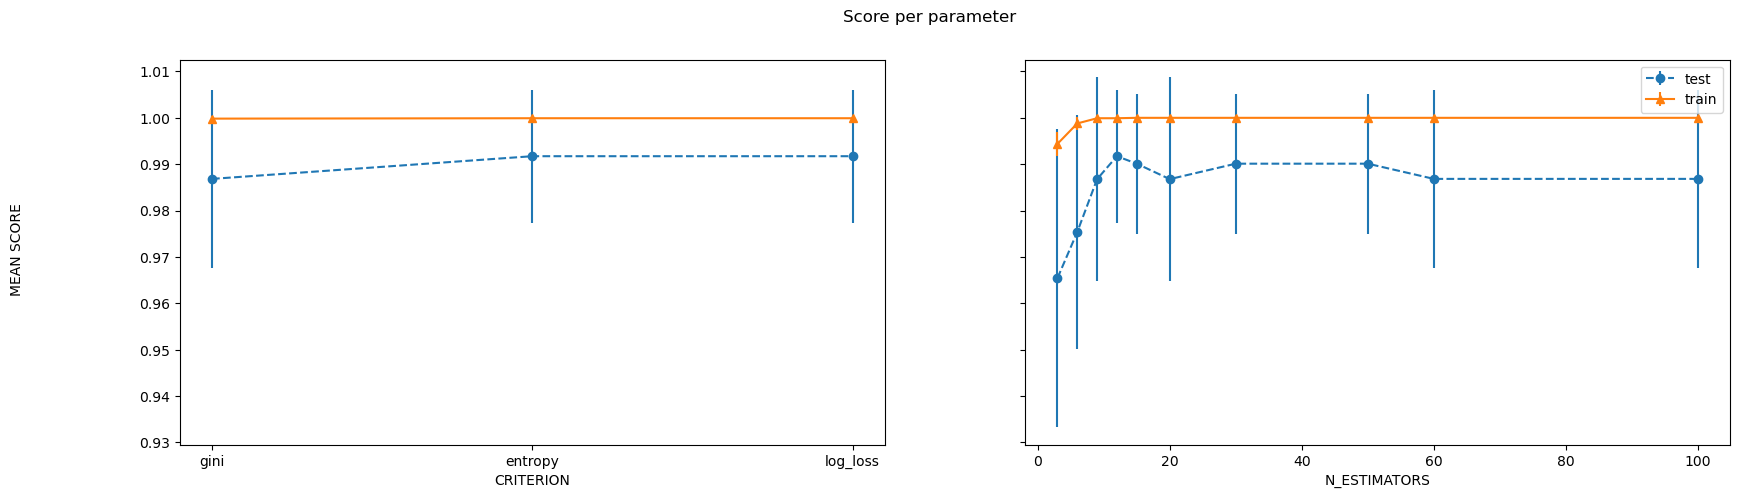

In [32]:
from sklearn.model_selection import GridSearchCV
parameters = { 'n_estimators':[3, 6, 9, 12, 15, 20, 30, 50, 60, 100], 
               'criterion':('gini','entropy','log_loss'),
             }

RFst = RandomForestClassifier(class_weight='balanced', random_state=52)
clf = GridSearchCV(RFst, parameters, cv=20,  return_train_score=True)

clf.fit(X_train, y_train)

plot_search_results(clf)

In [33]:
print(f' Number of rows to average: {N}, number of rows to train/test: {rLen}, {clf.best_params_}, Score: {clf.best_score_}')

 Number of rows to average: 18, number of rows to train/test: 20, {'criterion': 'entropy', 'n_estimators': 12}, Score: 0.9917204301075268


In [34]:
#with all the samples 5LDR:
# Number of rows to average: 18, number of rows to train/test: 20, {'criterion': 'entropy', 'n_estimators': 12}, Score: 0.9917204301075268

## Random Forest

In [35]:
#training the model
from sklearn.datasets import make_classification

#Split data into test and training data sets
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.40, random_state=45,stratify=np.array(y3)) 


model = RandomForestClassifier(random_state=42,n_estimators=12,criterion='entropy',class_weight='balanced')

model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = model.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
0.9847242380261247


Confusion Matrix:
[[42  0  0  0  0  0  0]
 [ 0 43  1  0  0  0  0]
 [ 0  0 44  0  0  0  0]
 [ 0  0  0 43  0  0  0]
 [ 0  1  0  0 42  1  0]
 [ 0  0  0  0  2 42  0]
 [ 0  0  0  0  0  0 88]]


Test Statistics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       0.98      0.98      0.98        44
           2       0.98      1.00      0.99        44
           3       1.00      1.00      1.00        43
           4       0.95      0.95      0.95        44
           5       0.98      0.95      0.97        44
           6       1.00      1.00      1.00        88

    accuracy                           0.99       349
   macro avg       0.98      0.98      0.98       349
weighted avg       0.99      0.99      0.99       349



Testing Accuracy: 0.9856733524355301


In [36]:
model.n_features_in_
# model.n_features_

5